In [1]:
################################################################
# Import Python Libraries
################################################################
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

from Configure.Constants  import *
from Configure.AtomicData import *
from Configure.PlanetData  import *
from Configure.Conversions import amu2GeV

# Capture rate computation without darkphoton

Here we will tweak the DarkCapPy code to compute the capture rate assuming a constant cross-section for the $\chi$-SM scattering.

$\sigma^{SI} = 10^{-42} cm^2$


## Fourth attempt

We'll go for the same code as the third attempt.

The spin-independent cross section on a nucleus with atomic number A as : 

\begin{equation}
    \sigma^{SI}_{\chi A} = \sigma^{SI}A^2\frac{(m_\chi m_A)^2}{(m_\chi + m_A)^2}\frac{(m_\chi + m_p)^2}{(m_\chi m_p)^2} =  \sigma^{SI}A^2\left(\frac{m_\chi + m_p}{m_\chi + m_A}\frac{m_A}{m_p}\right)^2
\end{equation}

where $m_p$ is the proton mass

### 1) Integrating up to the galactic escape velocity

This time the equation will be :

\begin{equation}
    C_{Cap}^N = n_\chi\sigma_{\chi A}^{SI}\int_0^{R_\oplus}dr4\pi r^2n_N(r)\int_0^{v_{gal}} 4\pi u^2f_\oplus(u)\frac{u^2 + v_\oplus^2(r)}{u}
\end{equation}

Where we now integrate over the whole range of velocity that the wimp can access from 0 to the galactic escape velocity

In [3]:
def crossSection(element, mx) :
    A = atomicNumbers[element]
    sigma = 1e-42* (5.06 * 10 ** 13) ** 2 #cm^2 to GeV^-2
    mp = 0.938272
    ma = amu2GeV(A)
    
    crossSection = sigma * A **2 * ((mx + mp) * ma / (mx + ma ) / mp) **2
    
    return crossSection

In [18]:

########################
# Photon VelocityIntegration
########################
def intDuDEr(element, m_X, rIndex):
	'''
	intDuDER(element, m_X, m_A, rIndex):

	Returns the evaluated velocity integrals for wimp scattering

	[m_X] = GeV
	'''
	m_i = amu2GeV(atomicNumbers[element])
    
	def integrand(u):
		fu = fCrossInterp(u)
		integrand =  u * fu * (u ** 2 + escVel2_List[rIndex])

		return integrand
    
	uLow = 0
	uHigh = V_gal
	integral = integrate.quad(integrand, uLow, uHigh)[0]

	return integral



Let's compute those integral for a few mx value distributed logarithmically over the 10-100GeV range

In [19]:
mx = np.logspace(1, 2, 20)

```Python
velocityIntegral = np.empty((len(radius_List), len(element_List), len(mx)))
for i in range(len(radius_List)) :
    print(i)
    for j, element in enumerate(element_List) :
        for k, m in enumerate(mx) :
            velocityIntegral[i, j, k] = intDuDEr(element,m, i)
np.save('data/NP4_velocityIntegral', velocityIntegral) 
```

As I already computed those value, it is faster to just recall the data saved in a npy file

In [21]:
velocityIntegral = np.load('data/NP4_velocityIntegral.npy')

We now sum over all radi for each element and wimp mass

In [22]:
def sumOverRVect(element, m_X) :
    
    radius = np.array(radius_List)
    deltaR = np.array(deltaR_List)
    n_N = np.array(numDensity_Func(element))
    
    j = np.where(element_List == element)[0][0]
    k = np.where(mx == m_X)[0][0]
    
    tempSum = radius ** 2 * n_N * deltaR * velocityIntegral[: , j , k] #Here it would be better if I could
    #just contract the whole 3D array with the 1D ones. I tried n_N[:, None, None] * radius[:, None, None] ** 2
    # etc.. But it did not give the same results.
    
    return np.sum(tempSum)

In [23]:

sumOverRadi = np.empty((len(mx), len(element_List)))

for j, element in enumerate(element_List) :
    for k, m in enumerate(mx) :
        sumOverRadi[k, j] = sumOverRVect(element, m)
        

In [24]:
sumOverRadi = pd.DataFrame(data = sumOverRadi)
sumOverRadi.columns = element_List

In [25]:
sumOverRadi

,O16,Na,Mg,Al,Si,P,S,Ca,Cr,Fe,Ni
0,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
1,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
2,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
3,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
4,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
5,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
6,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
7,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
8,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42
9,4.197353e+44,1.791755e+42,1.449995e+44,1.328455e+43,1.300282e+44,5.297211e+41,4.429260e+42,9.653912e+42,2.019516e+42,1.278910e+44,6.904787e+42


In [26]:
def singleElementCap(element, m_X):
	'''
	singleElementCap(element, m_X)

	Returns the capture rate due to a single element for the specified parameters

	[m_X] = GeV
	'''
	n_X = 0.3/m_X # GeV/cm^3

	conversion = (5.06e13)**-3 * (1.52e24) # Conversion to seconds (cm^-3)(GeV^-2) -> (s^-1)
	prefactors = (4*np.pi)**2
	function = n_X * conversion * prefactors * sumOverRadi[element][np.where(mx == m_X)[0]] * crossSection(element, m)
	return function

In [27]:
########################
# Full Capture Rate
########################
def cCap(m_X):
	'''
	cCap(m_X, m_A, epsilon, alpha, alpha_X)

	returns the full capture rate in sec^-1 for the specified parameters

	Note: This function is the less efficient way to perform this calculation. Every point in (m_A, epsilon) space 
		involves peforming the full tripple integral over recoil energy, incident DM velocity, and Earth radius
		which is time consuming.

	[m_X] = GeV
	'''
	totalCap = 0
	for element in element_List:
		elementCap = singleElementCap(element, m_X)
		totalCap += elementCap 
	return totalCap


In [28]:
capNoPhoton = np.empty_like(mx)

In [29]:

for i, m in enumerate(mx) :
    capNoPhoton[i] = cCap(m)


And plot it !

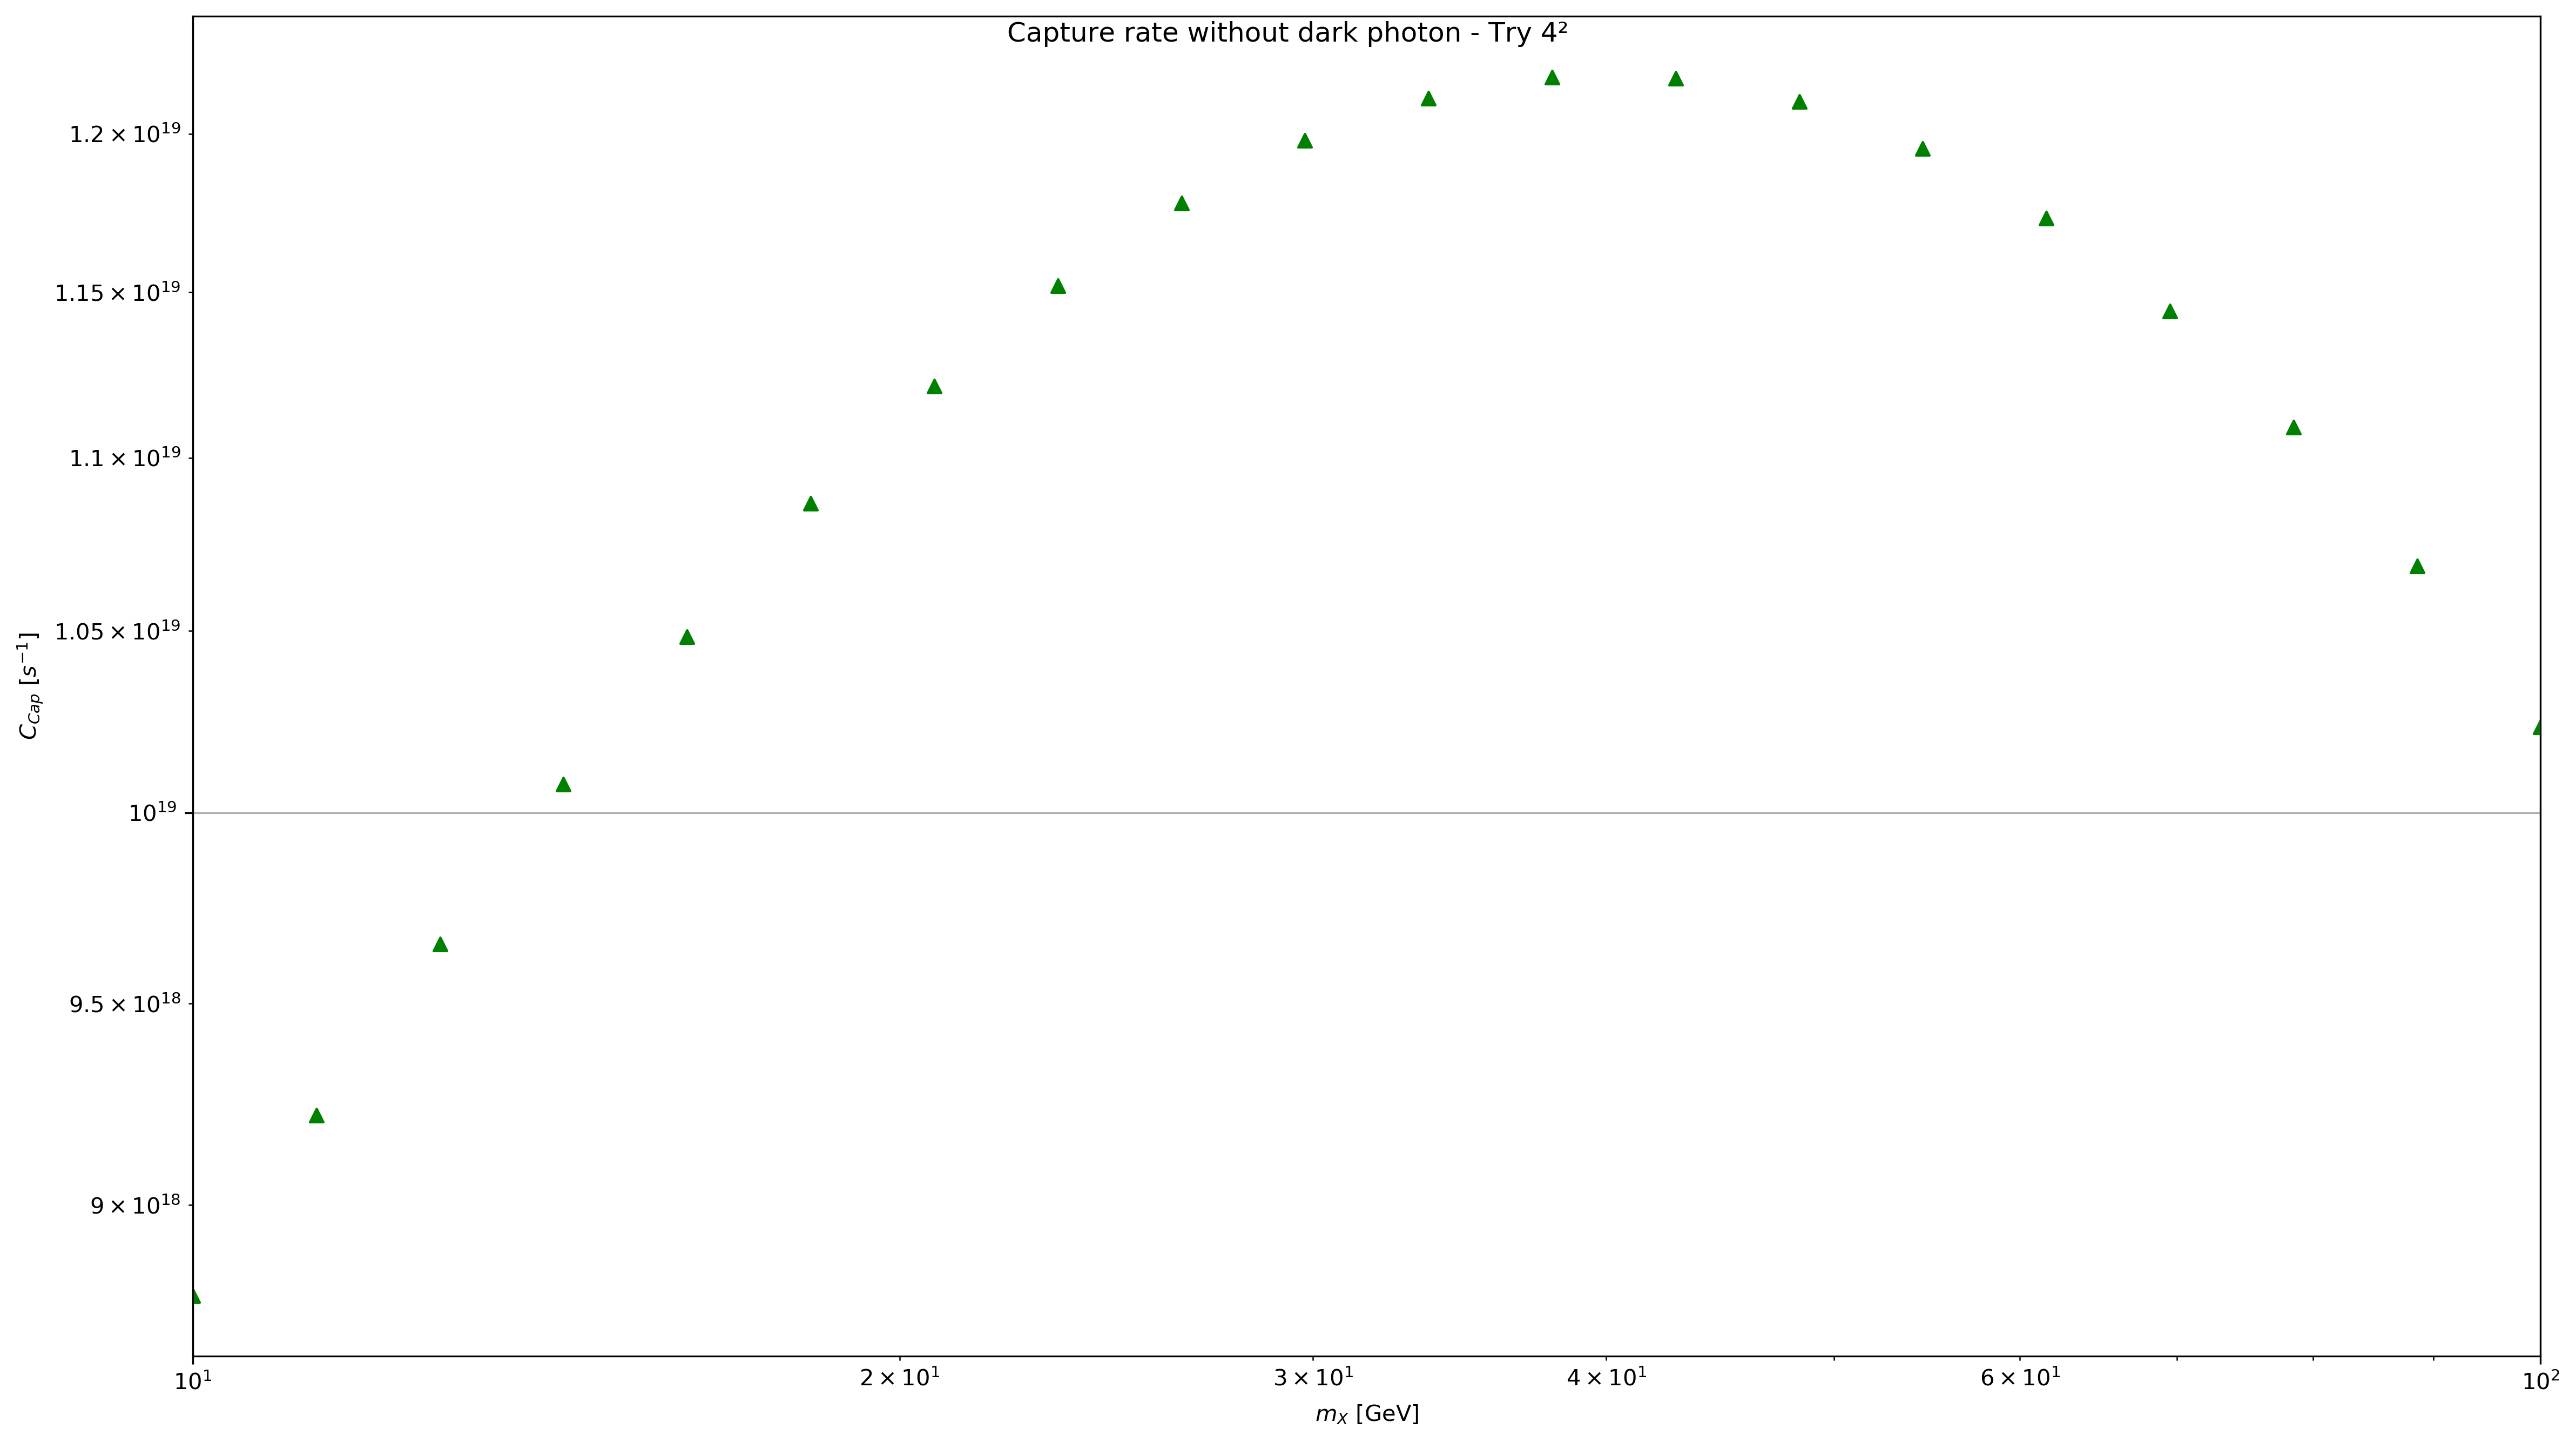

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)

ax.scatter(mx, capNoPhoton, marker = '^', color = 'g')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 100)
ax.grid()

ax.set_ylabel('$C_{Cap}$ [$s^{-1}$]')
ax.set_xlabel('$m_X$ [GeV]')

fig.suptitle("Capture rate without dark photon - Try 4")
fig.tight_layout()

In [33]:
fig.savefig("data/Capture_rate_NP4.1.png")

Something's off. It seems that integrating up to the galactic escape velocity smooth out resonnances.. (Althouth the maximum capture rate seems to match iron mass.

### 2) Setting an upper limit on captured wimp initial velocity

Because we consider an elastic wimp-nucleus scattering, it is easy to compute the maximum final wimp velocity, as a function of the wimp initial velocity, its mass, and the mass of the element on which it scatters.

Setting ourselves in the earth reference frame, and supposing the atoms on which wimp scatters are at rest in this frame, conseration of energy and momentum gives us :

$$
\begin{align}
    \vec{p_{\chi_{i}}} &= \vec{p_{\chi_{f}}} + \vec{p_{N_{f}}} \\
    m_\chi v_{\chi_i}^2 &= m_\chi v_{\chi_f}^2 + m_N v_{N_f}^2
\end{align}
$$

Squaring the first equation, we obtain :

$$
\begin{align}
     v_{\chi_i}^2 &=   v_{\chi_f}^2 +  \frac{m_N^2}{m_\chi^2} v_{N_f}^2 + 2\frac{ m_N}{m_\chi} v_{N_f}\cdot v_{\chi_f} \cos(\theta)\\
     v_{\chi_i}^2 &=  v_{\chi_f}^2 + \frac{m_N}{m_\chi} v_{N_f}^2
\end{align}
$$

where $\theta$ is defined as the angle between $\vec{v_{\chi_f}}$ and $\vec{v_{N_f}}$

As we want the wimp to be captured, we can set an upper limit on $v_{\chi_f}$ : earth's escape velocity at radius r. But we do not have an upper limit for the final velocity of the nucleus the wimp scattered on. We can use the above equations to express $v_{N_f}$ in terms of the other parameters :

$$
\begin{align}
    v_{\chi_f}^2 + \mu v_{N_f}^2 &= v_{\chi_f}^2 +  \mu^2 v_{N_f}^2 + 2\mu v_{N_f}\cdot v_{\chi_f} \cos(\theta) \\
    v_{N_f} &= \mu v_{N_f} + 2v_{\chi_f}\cos(\theta) \\
    v_{N_f}(1-\mu) &= 2v_{\chi_f}\cos(\theta) \\
    v_{N_f} &= \frac{2\cos(\theta)}{1-\mu}v_{\chi_f}
\end{align}
$$

Where we introduced $\mu = \frac{m_N}{m_\chi}$.
Using the second conservation equation, and replacing the final velocity of the nucleus by the expression we just derive we get :

\begin{equation}
    v_{\chi_i}^2 = v_{\chi_f}^2\left(1 + \frac{\mu}{(1-\mu)^2}4\cos^2(\theta)\right)
\end{equation}

Setting the limit : $v_{\chi_f}(r) \leq v_\oplus(r)$, the above equation becomes :

\begin{align}
    v_{\chi_i}^2 &\leq v_\oplus^2\left(1 + \frac{\mu}{(1-\mu)^2}4\cos^2(\theta)\right) \\
    &\leq v_\oplus^2\left(1 + \frac{\mu}{(1-\mu)^2}4\right) \\
    &\leq v_\oplus^2\left(\frac{1+\mu}{1-\mu}\right)^2 = v_\oplus^2\left(\frac{m_\chi + m_N}{m_\chi - m_N}\right)^2
\end{align}

We now have an upper limit on the wimp initial velocity, that we can use as an upper bound for the velocity integration :

\begin{equation}
    v_{\chi_i} \leq v_\oplus\left|\frac{m_\chi + m_N}{m_\chi - m_N}\right|
\end{equation}

In [39]:

########################
# Photon VelocityIntegration
########################
def intDuDEr(element, m_X, rIndex):
	'''
	intDuDER(element, m_X, m_A, rIndex):

	Returns the evaluated velocity integrals for wimp scattering

	[m_X] = GeV
	'''
	m_i = amu2GeV(atomicNumbers[element])
    
	def integrand(u):
		fu = fCrossInterp(u)
		integrand =  u * fu * (u ** 2 + escVel2_List[rIndex])

		return integrand

	uMax = np.sqrt(escVel2_List[rIndex]) * np.abs((m_X + m_i) / (m_X - m_i))
	uLow = 0
	uHigh = min(uMax, V_gal)
	integral = integrate.quad(integrand, uLow, uHigh)[0]

	return integral



In [40]:
mx = np.logspace(1, 2, 20)

```Python
velocityIntegral = np.empty((len(radius_List), len(element_List), len(mx)))
for i in range(len(radius_List)) :
    for j, element in enumerate(element_List) :
        for k, m in enumerate(mx) :
            velocityIntegral[i, j, k] = intDuDEr(element,m, i)
np.save('data/NP4.2_velocityIntegral', velocityIntegral) 
```

In [42]:
velocityIntegral = np.load('data/NP4.2_velocityIntegral.npy')

In [43]:

sumOverRadi = np.empty((len(mx), len(element_List)))

for j, element in enumerate(element_List) :
    for k, m in enumerate(mx) :
        sumOverRadi[k, j] = sumOverRVect(element, m)
        

In [44]:
sumOverRadi = pd.DataFrame(data = sumOverRadi)
sumOverRadi.columns = element_List

In [45]:
capNoPhoton = np.empty_like(mx)
for i, m in enumerate(mx) :
    capNoPhoton[i] = cCap(m)


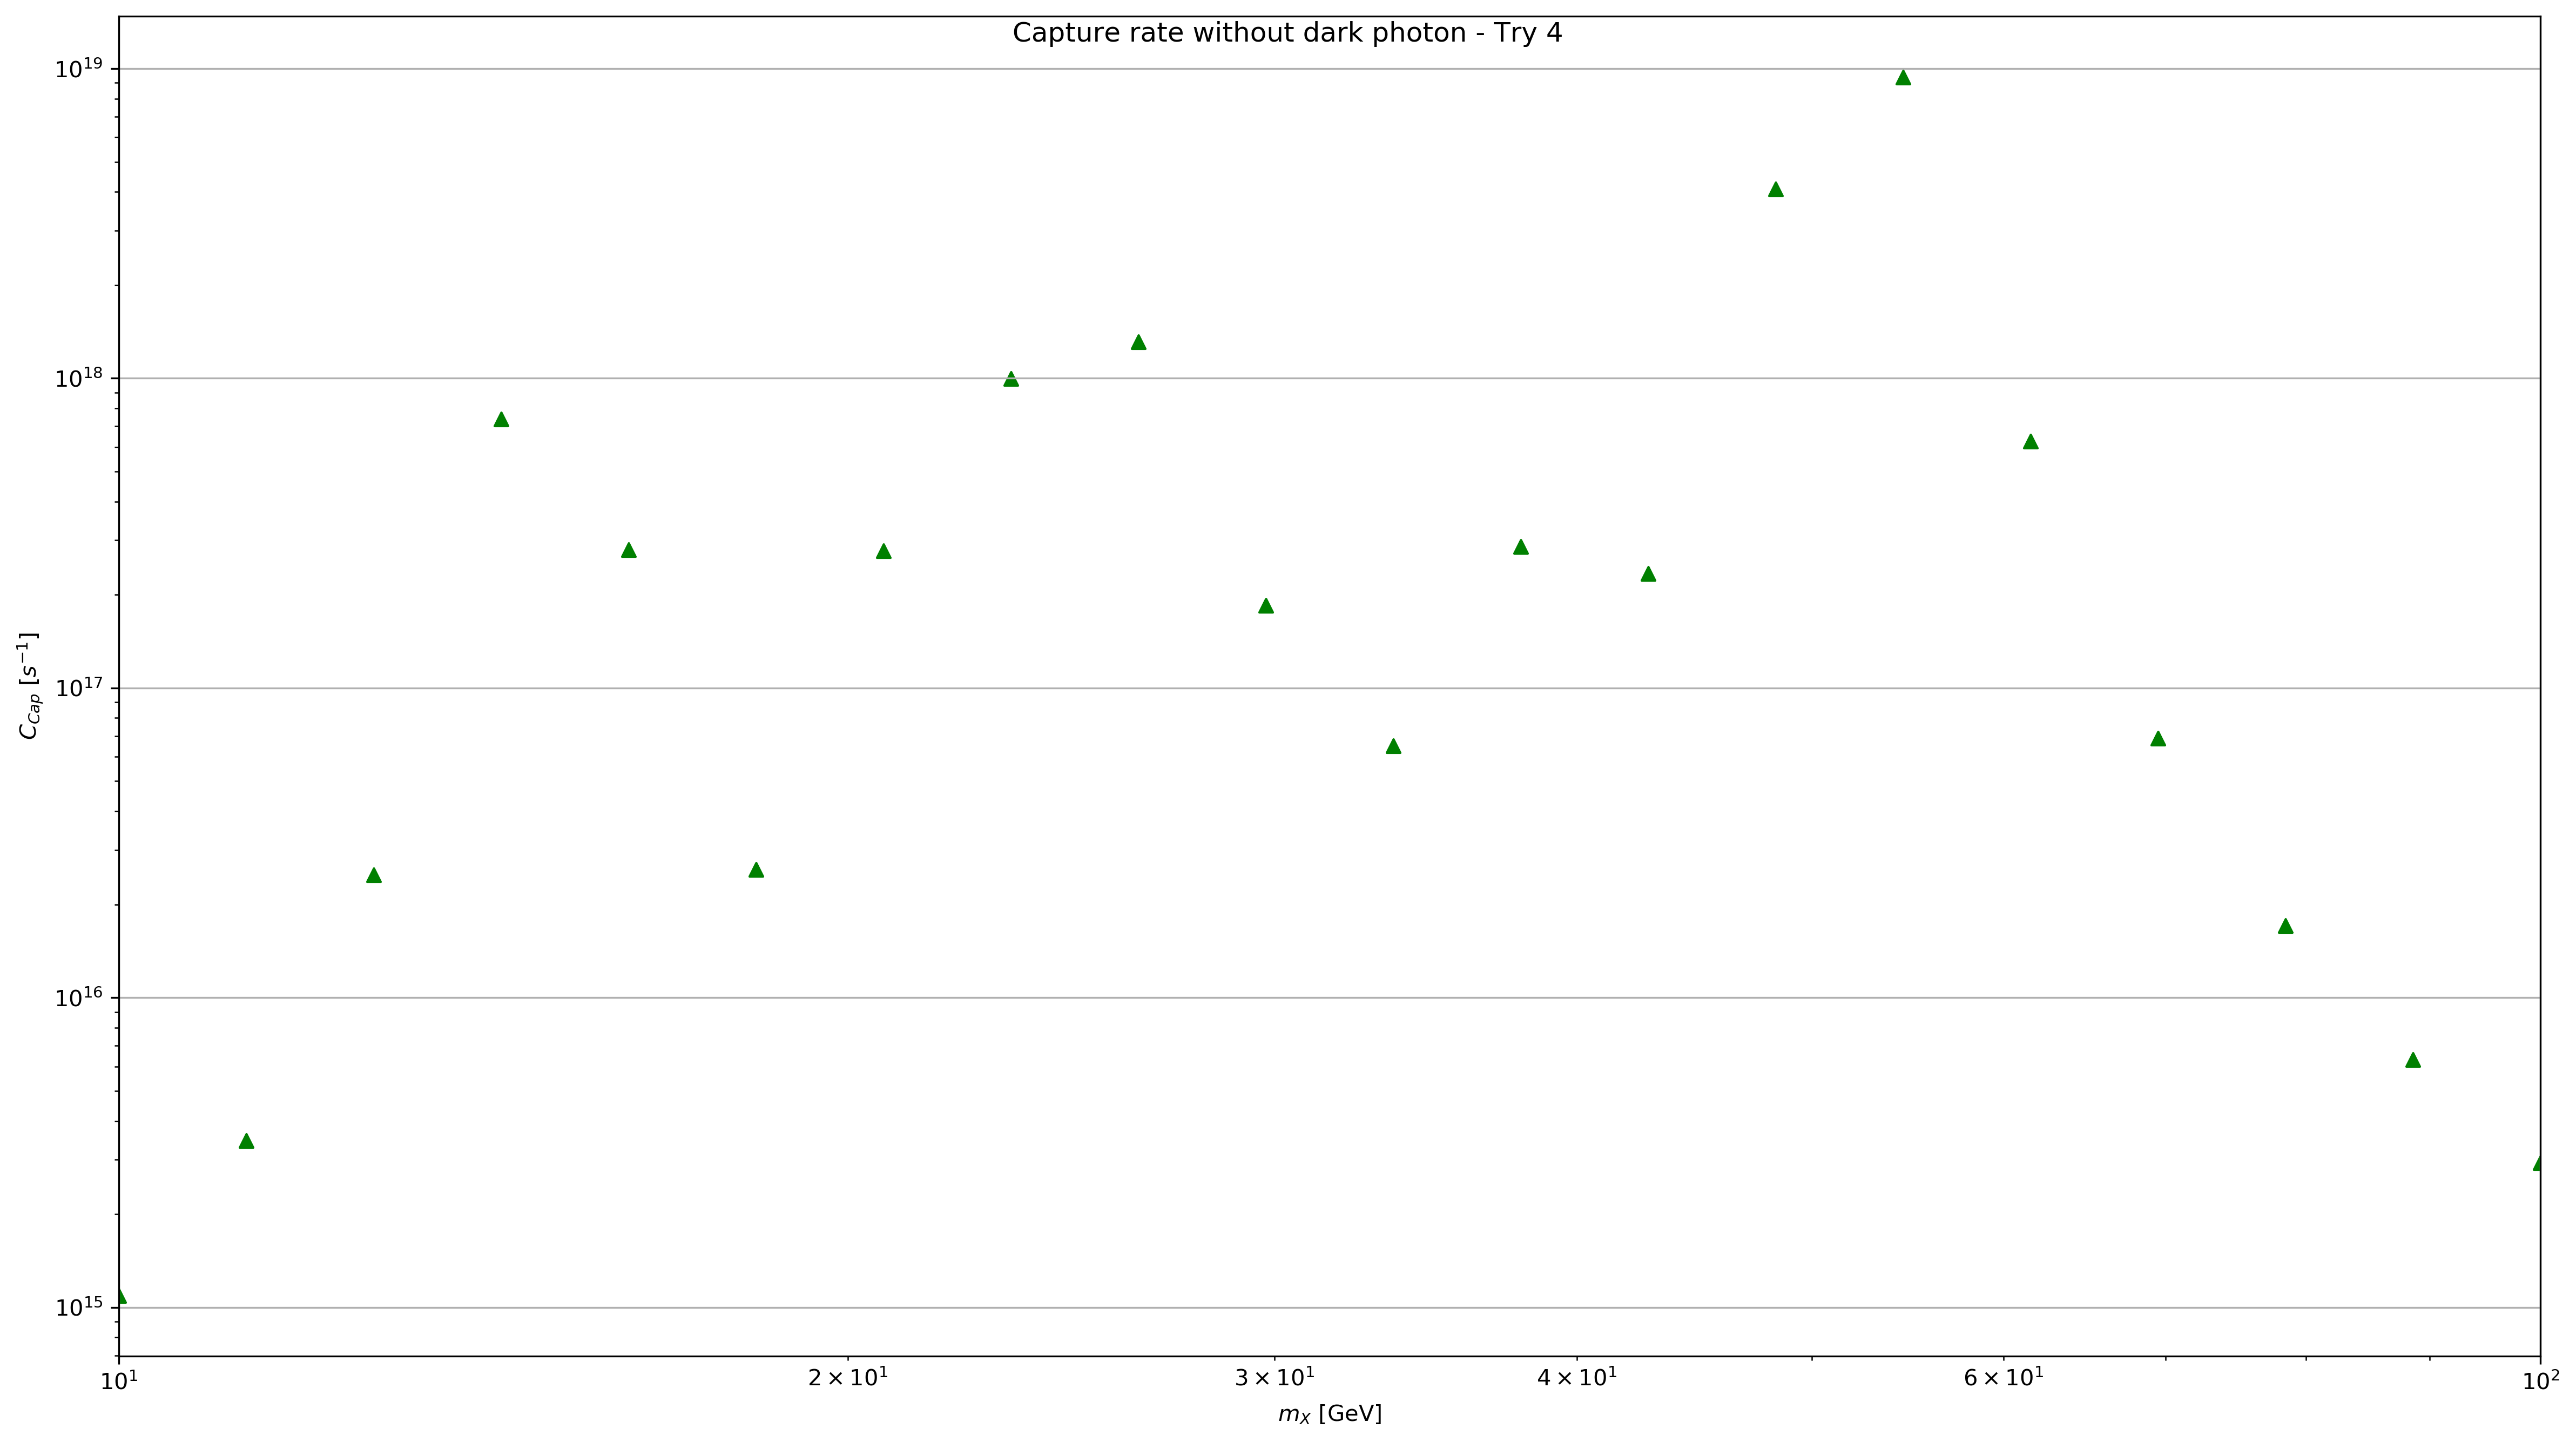

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)

ax.scatter(mx, capNoPhoton, marker = '^', color = 'g')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 100)
ax.grid()

ax.set_ylabel('$C_{Cap}$ [$s^{-1}$]')
ax.set_xlabel('$m_X$ [GeV]')

fig.suptitle("Capture rate without dark photon - Try 4")
fig.tight_layout()

Ok, this seems to work out alright, let's compute it over the whole $m_\chi$ range.

### 3) Computation over the 10 - 10000 GeV $m_\chi$ range

#### 3.1) Computing the velocity integrals


In [47]:
mx = np.logspace(1, 4, 200)

In [66]:
def computeIntegral(mx) :
    '''
    Loop over all radi, all elements, and all dark matter masses of the intDuDEr function
    
    Inputs :
        -mx : numpy.1darray
        Array of dark matter masses to compute the capture rate for
        
    Outputs :
        -velocityIntegral : numpy.3darray
        An array containing all the computed velocity integral needed to compute the capture rate
    '''
    
    velocityIntegral = np.empty((len(radius_List), len(element_List), len(mx)))
    for i in range(len(radius_List)) :
        for j, element in enumerate(element_List) :
            for k, m in enumerate(mx) :
                velocityIntegral[i, j, k] = intDuDEr(element, m, i)
    return velocityIntegral

```Python
velocityIntegral = computeIntegral(mx)
np.save('data/NP4.3_velocityIntegral.npy', velocityIntegral)
```

In [52]:
velocityIntegral = np.load('data/NP4.3_velocityIntegral.npy')

####  3.2) Summing over all radi



In [53]:
def sumOverRVect(element, m_X) :
    
    radius = np.array(radius_List)
    deltaR = np.array(deltaR_List)
    n_N = np.array(numDensity_Func(element))
    
    j = np.where(element_List == element)[0][0]
    k = np.where(mx == m_X)[0][0]
    
    tempSum = radius ** 2 * n_N * deltaR * velocityIntegral[: , j , k] #Here it would be better if I could
    #just contract the whole 3D array with the 1D ones. I tried n_N[:, None, None] * radius[:, None, None] ** 2
    # etc.. But it did not give the same results.
    
    return np.sum(tempSum)

In [54]:

sumOverRadi = np.empty((len(mx), len(element_List)))

for j, element in enumerate(element_List) :
    for k, m in enumerate(mx) :
        sumOverRadi[k, j] = sumOverRVect(element, m)
        

In [59]:
sumOverRadi = pd.DataFrame(data = sumOverRadi)
sumOverRadi.columns = element_List

#### 3.3) Computing the capture rate


In [60]:
sumOverRadi

,O16,Na,Mg,Al,Si,P,S,Ca,Cr,Fe,Ni
0,4.486367e+41,2.035689e+38,1.386328e+40,8.362201e+38,7.941787e+39,4.064241e+37,2.945976e+38,2.328490e+38,4.713912e+37,3.054500e+39,1.593769e+38
1,6.255848e+41,2.366552e+38,1.594274e+40,9.380889e+38,8.852128e+39,4.480805e+37,3.219159e+38,2.484994e+38,4.938315e+37,3.187065e+39,1.658649e+38
2,9.037285e+41,2.778189e+38,1.849528e+40,1.059362e+39,9.927320e+39,4.966224e+37,3.534042e+38,2.660246e+38,5.183961e+37,3.331468e+39,1.729100e+38
3,1.362119e+42,3.296581e+38,2.166274e+40,1.204917e+39,1.120680e+40,5.535559e+37,3.899065e+38,2.857235e+38,5.453532e+37,3.489118e+39,1.805760e+38
4,2.162232e+42,3.958219e+38,2.564031e+40,1.381170e+39,1.274181e+40,6.207987e+37,4.324798e+38,3.079552e+38,5.750136e+37,3.661636e+39,1.889357e+38
...,...,...,...,...,...,...,...,...,...,...,...
195,2.067893e+39,8.862998e+36,7.176593e+38,6.586412e+37,7.014916e+38,4.389027e+36,3.769998e+37,4.822336e+37,1.478062e+37,1.053491e+39,5.850601e+37
196,2.067244e+39,8.858996e+36,7.173212e+38,6.582920e+37,7.011059e+38,4.386441e+36,3.767629e+37,4.818545e+37,1.476550e+37,1.052330e+39,5.843810e+37
197,2.066617e+39,8.855133e+36,7.169947e+38,6.579549e+37,7.007335e+38,4.383945e+36,3.765342e+37,4.814886e+37,1.475092e+37,1.051211e+39,5.837260e+37
198,2.066012e+39,8.851403e+36,7.166796e+38,6.576295e+37,7.003741e+38,4.381536e+36,3.763135e+37,4.811356e+37,1.473685e+37,1.050131e+39,5.830940e+37


In [61]:
def singleElementCapVect(element, m_X):
	'''
	singleElementCap(element, m_X)

	Returns the capture rate due to a single element for the specified parameters

	[m_X] = GeV
	'''
	n_X = 0.3/m_X # GeV/cm^3

	conversion = (5.06e13)**-3 * (1.52e24) # Conversion to seconds (cm^-3)(GeV^-2) -> (s^-1)
	prefactors = (4*np.pi)**2
	function = n_X * conversion * prefactors * sumOverRadi[element].values * crossSection(element, m_X)
	return function

In [62]:

def cCapVect(m_X):
	'''
	cCap(m_X, m_A, epsilon, alpha, alpha_X)

	returns the full capture rate in sec^-1 for the specified parameters

	Note: This function is the less efficient way to perform this calculation. Every point in (m_A, epsilon) space 
		involves peforming the full tripple integral over recoil energy, incident DM velocity, and Earth radius
		which is time consuming.

	[m_X] = GeV
	'''
	totalCap = 0
	elementCapList = np.empty_like(element_List)
	for i, element in enumerate(element_List):
		elementCap = singleElementCapVect(element, m_X)
		elementCapList[i] = elementCap
		totalCap += elementCap 
	return (totalCap, elementCapList)


In [63]:
capNoPhoton, capNoPhotonElement = cCapVect(mx)

And plot it !

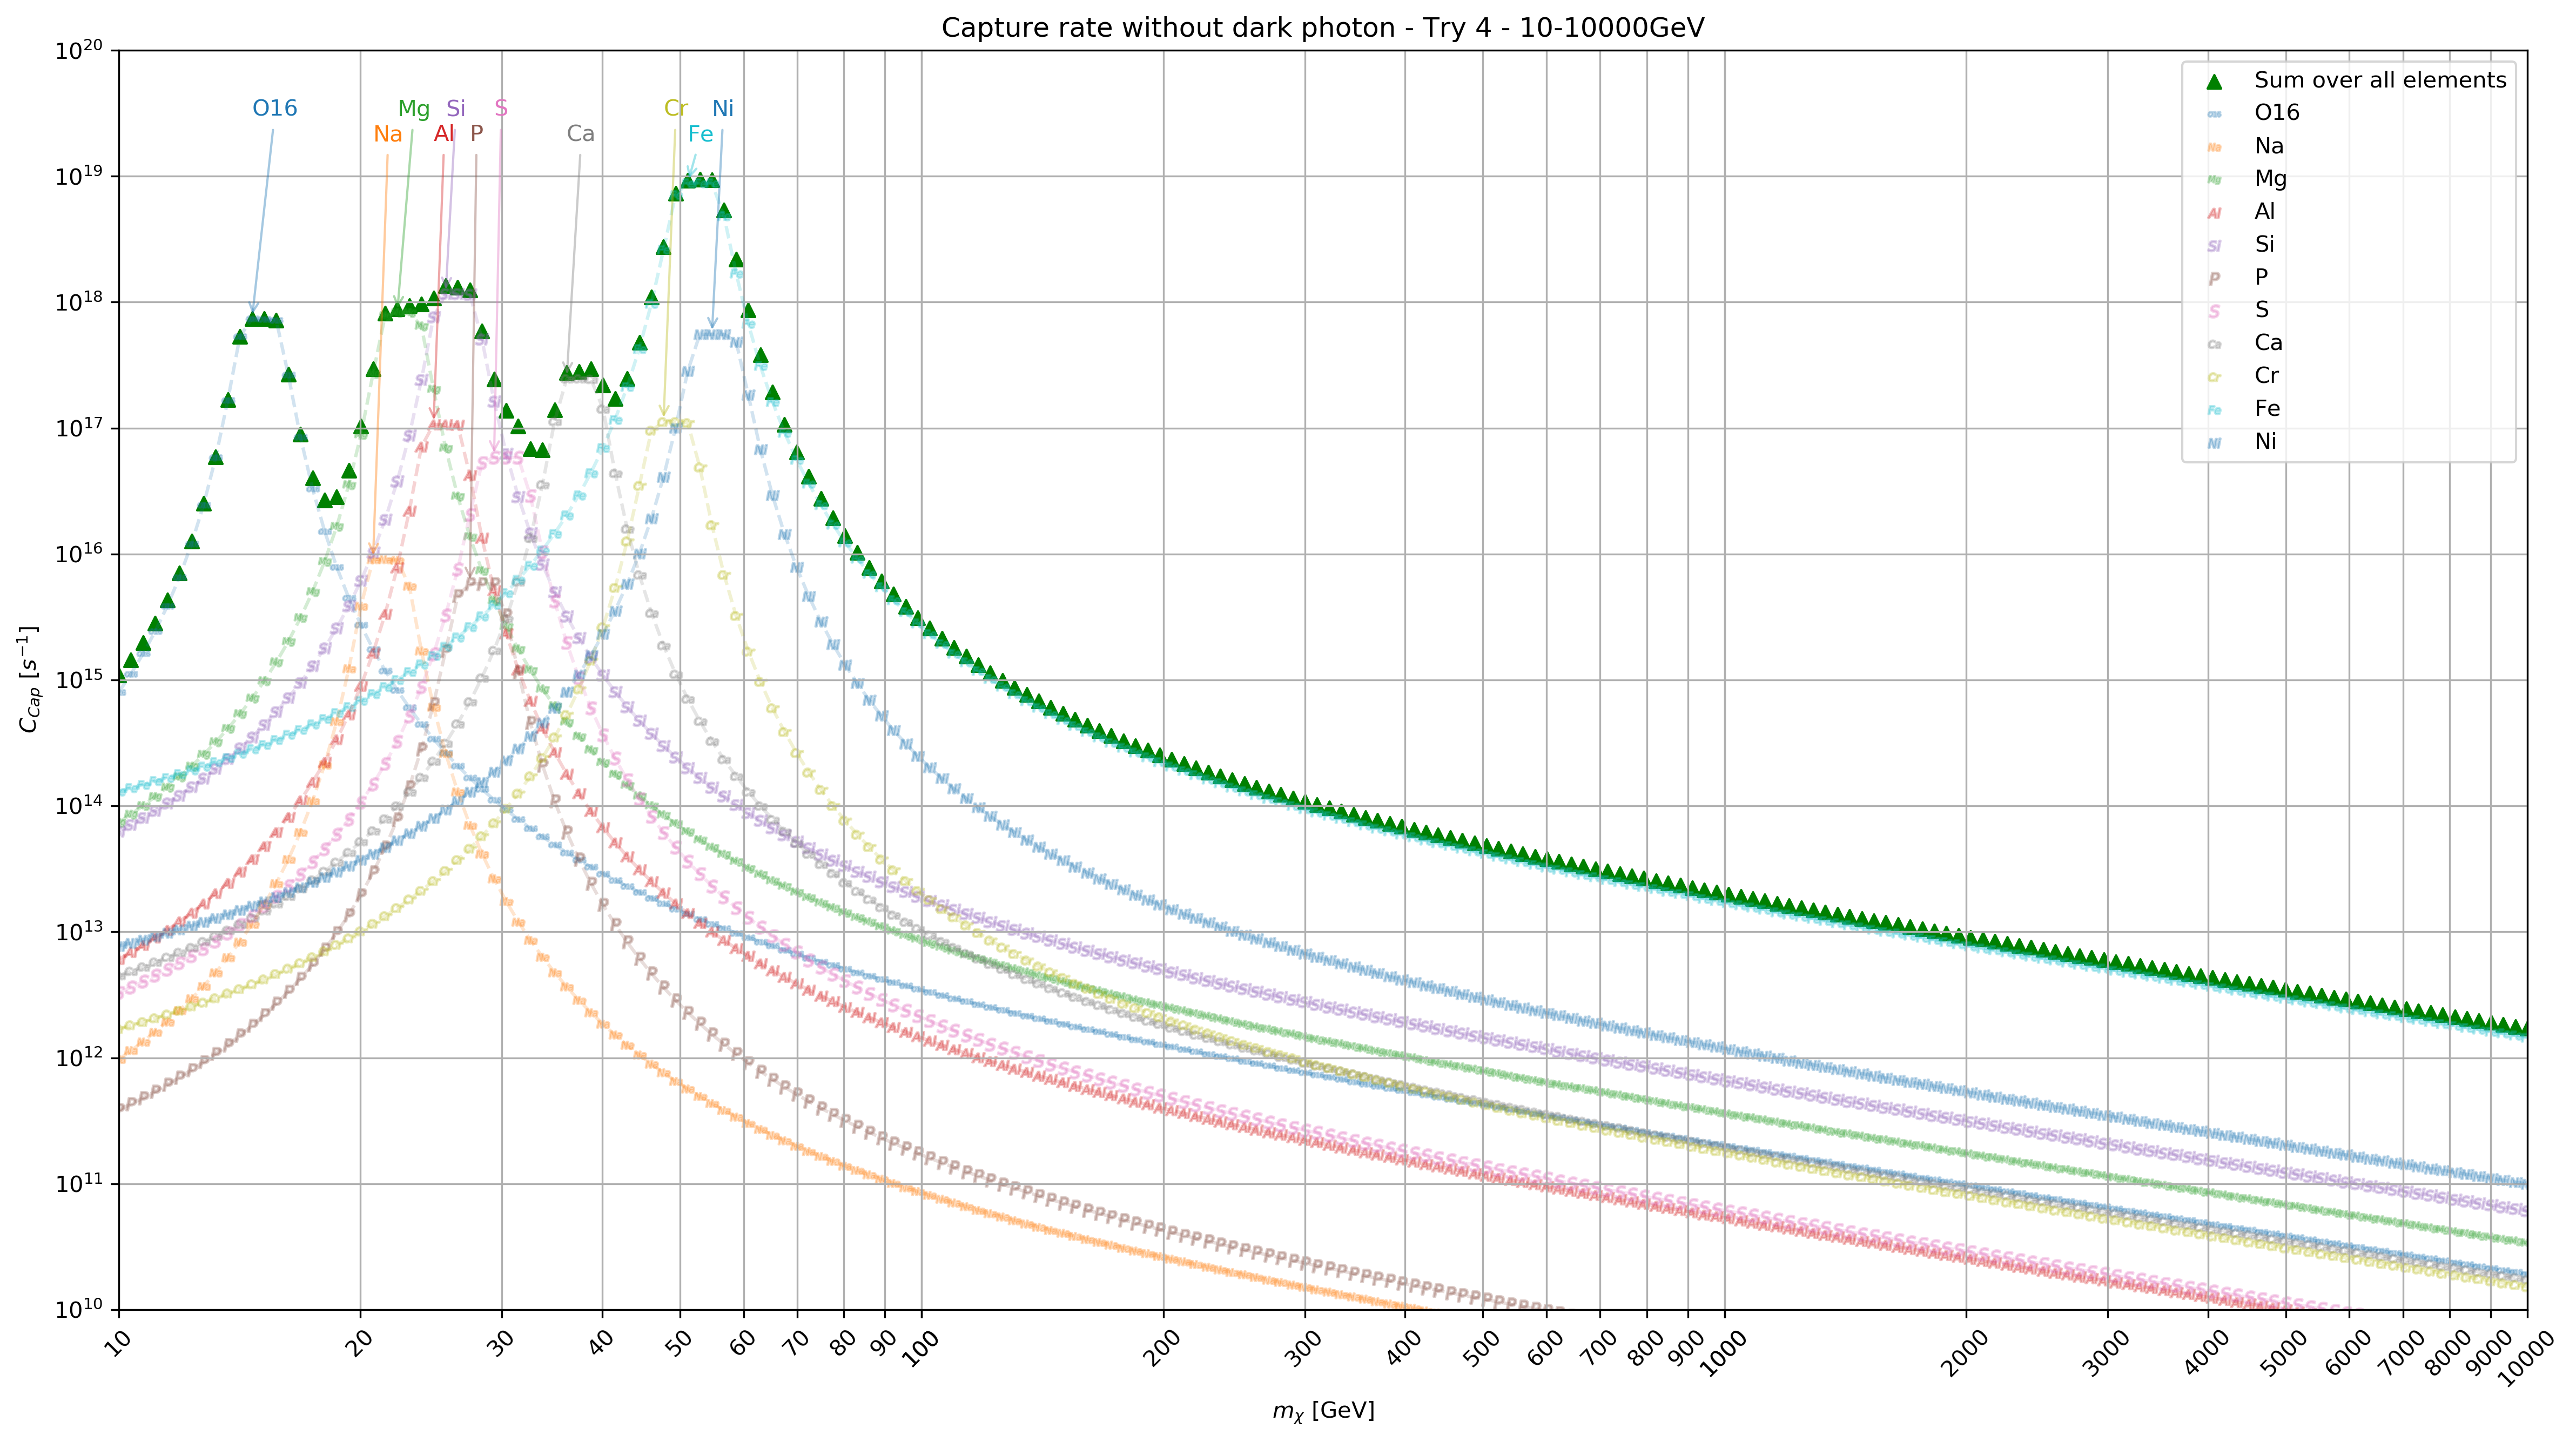

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)


ax.scatter(mx, capNoPhoton, marker = '^', color = 'g', label = 'Sum over all elements')

for i, capElement in enumerate(capNoPhotonElement) :
    
    
    y = np.amax(capElement)
    x = mx[np.where(capElement == y)]
    
    ax.scatter(mx, capElement, label = element_List[i], marker = '$'+element_List[i]+'$',
               s = 30, color = ('C' + str(i)), alpha = 0.3)    
    ax.plot(mx, capElement, ls = '--', color = ('C' + str(i)), alpha = 0.2)
    
    if i % 2 == 0 :
        y_offset = 10 ** 19
    else :
        y_offset = -10 ** 18
        
    ax.annotate(element_List[i], (x, y),
               xytext = (x, 2 * 10**19 + y_offset), 
                arrowprops = dict(arrowstyle = '->', color = ('C' + str(i)), alpha = 0.4), color = ('C' + str(i)))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 10000)
ax.set_ylim(np.amin(capNoPhoton))

ax.set_yticks(np.logspace(10, 20, 11))
x_ticks = np.concatenate((np.linspace(10, 100, 10), 
                                    np.linspace(10, 100, 10)*10, np.linspace(10, 100, 10)*100)).astype(int)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation = 45)
ax.grid()

ax.legend()
ax.set_ylabel('$C_{Cap}$ [$s^{-1}$]')
ax.set_xlabel('$m_\chi$ [GeV]')

ax.set_title("Capture rate without dark photon - Try 4 - 10-10000GeV")
fig.tight_layout()

In [65]:
fig.savefig('data/capture_rate_NP4200')